In [7]:
import os
import tqdm
import cluster
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import cut_tree
from scipy.misc import comb
import itertools as it
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

In [2]:
allpdbs = [i.split('.')[0] for i in os.listdir("active_sites/") if i.endswith('.pdb')]
simmat = pd.read_pickle('sim.300.50.70.pkl')
Z, sitedict = cluster.cluster_hierarchically(allpdbs, simmat)

In [3]:
def get_flats(Z,C,k):
    flat_hier = np.ravel(cut_tree(Z,k))
    flat_part = np.zeros(len(allpdbs),dtype=int)
    clust = -1
    for i in C.values():
        clust += 1
        for j in i:
            flat_part[j] = clust
    return flat_hier, flat_part

def get_agree(flat_part, flat_hier):
    combos = it.combinations(range(len(allpdbs)),r=2)
    agree = 0
    for i in combos:
        if flat_hier[i[0]] == flat_hier[i[1]]:
            hier_same = True
        else:
            hier_same = False
        if flat_part[i[0]] == flat_part[i[1]]:
            flat_same = True
        else:
            flat_same = False
        if hier_same == flat_same:
            agree += 1
    return agree

In [6]:
values = list()
errors = list()
numbers = list()
for k in tqdm(range(len(allpdbs))):
    repeatrands = list()
    for _ in range(20):
        # this must be placed in try block because 
        # cluster by partitionining will error stochastically but
        # with increasing frequency as the number of clusters requested 
        # increases
        try: 
            M, C, sitedict = cluster.cluster_by_partitioning(allpdbs,simmat,k=k)
        except:
            continue
        flat_hier, flat_part = get_flats(Z,C,k)
        
        agree = get_agree(flat_part, flat_hier)
        
        rand = float(agree)/comb(len(allpdbs),2)
        
        repeatrands.append(rand)
    if len(repeatrands) >= 1: # if no rand index was able to be calculated, repeatrands might be zero
        values.append(np.average(repeatrands))
        errors.append(np.std(repeatrands))
        numbers.append(len(repeatrands))

A Jupyter Widget

/Users/student/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [21]:
calcs = np.array([values,errors,numbers])
np.save("calcs.npy",calcs)

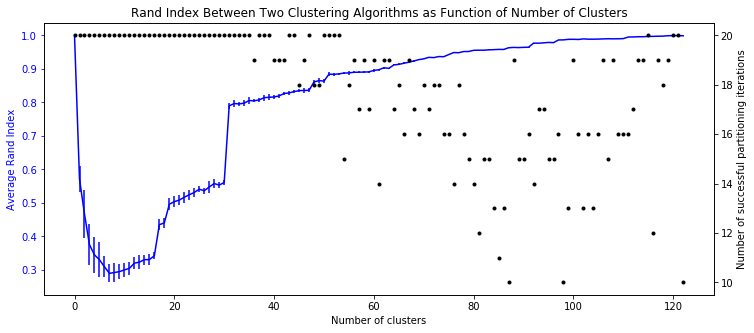

In [25]:
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.errorbar(range(len(values)), values, yerr=errors, color = 'b', linestyle='-')
ax1.set_xlabel('Number of clusters')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Average Rand Index', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(range(len(values)), numbers, 'k.')
ax2.set_ylabel('Number of successful partitioning iterations', color='k')
ax2.tick_params('y', colors='k')

plt.title("Rand Index Between Two Clustering Algorithms as Function of Number of Clusters")
plt.show()